The program is to find the longest possible path in a directed graph (doesn't have to be acyclic - the algorithm will try to do its best with it) crossing each node exactly once. It uses a generic algorithm provided by pygad library to compute the path.
<!-- By the by, it also checks if the graph is Hamiltonian or not.
"Graph G has a Hamiltonian path if and only if its longest path has length n − 1, where n is the number of vertices in G" -> https://en.wikipedia.org/wiki/Longest_path_problem -->

In [213]:
import networkx as nx
import random
import pygad
import matplotlib.pyplot as plt
import time
import math

Implementation of a small directed graph with 8 nodes.

In [214]:
G_small = nx.DiGraph()

# Adding nodes
G_small.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7])

# Adding edges with weights
G_small.add_edge(0, 1, weight=4)
G_small.add_edge(0, 2, weight=6)
G_small.add_edge(1, 3, weight=2)
G_small.add_edge(1, 4, weight=5)
G_small.add_edge(2, 3, weight=3)
G_small.add_edge(3, 5, weight=1)
G_small.add_edge(3, 6, weight=4)
G_small.add_edge(4, 3, weight=6)
G_small.add_edge(5, 7, weight=1)
G_small.add_edge(6, 7, weight=3)

# Finding the longest simple path
# draw_digraph(G_small)
longest_path_small = nx.dag_longest_path(G_small, weight='weight')
print("The longest simple path in the small graph is:", longest_path_small)

The longest simple path in the small graph is: [0, 1, 4, 3, 6, 7]


Implementation of a medium directed graph with 14 nodes.

In [215]:
G_medium = nx.DiGraph()

# Adding nodes
G_medium.add_nodes_from(range(14))

# Adding edges with random weights between 1 and 5
for i in range(13):
    for j in range(i+1, 14):
        if random.random() < 0.3:
            weight = random.randint(1, 6)
            G_medium.add_edge(i, j, weight=weight)

# Finding the longest simple path
# draw_digraph(G_medium)
longest_path_medium = nx.dag_longest_path(G_medium, weight='weight')
print("The longest simple path in the medium graph is:", longest_path_medium)

The longest simple path in the medium graph is: [0, 4, 5, 6, 7, 9, 10, 12, 13]


Implementation of a large directed graph with 20 nodes.

In [216]:
G_large = nx.DiGraph()

# Adding nodes
G_large.add_nodes_from(range(20))

# Adding edges with random weights between 1 and 5
for i in range(19):
    for j in range(i+1, 20):
        if random.random() > 0.4:
            weight = random.randint(1, 6)
            G_large.add_edge(i, j, weight=weight)

# Finding the longest simple path
# draw_digraph(G_large)
longest_path_large = nx.dag_longest_path(G_large, weight='weight')
print("The longest simple path in the large graph is:", longest_path_large)

The longest simple path in the large graph is: [0, 1, 4, 5, 7, 8, 9, 11, 12, 14, 15, 16, 17, 19]


Function for creating a random directed graph with a given number of nodes. The graph is created using the networkx library. Each node has a 50% chance of having an edge to another node. The edge weights are random numbers between 1 and 5.

In [217]:
def generate_digraph(num_nodes):
    G = nx.DiGraph()
    # Add nodes to the graph
    for i in range(num_nodes):
        G.add_node(i)
    # Add edges to the graph
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            if random.random() < 0.5:
                weight = random.randint(1, 6)
                G.add_edge(i, j, weight=weight)
    return G

Simple function for drawing the graph with weight labels on the edges.

In [218]:
def draw_digraph(graph):
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos=pos, with_labels=True)
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

Normalize solution function is to change the solution from a list of numbers between 0 and 99 which are used to choose indexes of the nodes we want to go to, to the very index of the node. It's used for better readability and because of the way the fitness function is implemented.

In [219]:
def normalize_solution(graph, solution):
    current_node = solution[0] % graph.number_of_nodes()
    normalized_solution = [current_node]
    
    for direction in solution[1:]: # Skip the first node as it is our starting point
        if direction % 2 == 1: # This line prevents the algorithm from going back to the previous node (making a cycle)
            break
        out_edges = list(graph.out_edges(current_node))
        if len(out_edges) == 0:
            break
        normalized_direction = (direction // 2) % len(out_edges)
        normalized_solution.append(normalized_direction)
        current_node = out_edges[normalized_direction][1]
    return normalized_solution

Convert solution to path function is to convert the solution from a list of indexes of the nodes to a list of nodes. It's used for better readability at the end of the program and for the fitness function to punish the solutions that go to the same node more than once.

In [220]:
def convert_solution_to_path(graph, solution):
	normalized_solution = normalize_solution(graph, solution)
	current_node = normalized_solution[0]
	path = [current_node]
	for norm_direction in normalized_solution[1:]:
		out_edges = list(graph.out_edges(current_node))
		current_node = out_edges[norm_direction][1]
		path.append(current_node)
	return path

Firstly, fitness function normalizes the solution (uses another function), so that it represents indexes of nodes instead of of a "random number (0, 99) % number of possible nodes to go". Then, it goes through every element of solution (direction), checks possible edges that we can choose to go through and updates current node with the direction (index) of out edges. It also updates current path length by adding the new edge weight to it. Next, fitness converts the solution to a real path representing numbers of nodes in specific order to go through and checks if any node was visited more than once. If so, it punishes the fitness result harshly, as we only want result paths to be simple. It's worth to mention, that the algorithm selects the starting point itself for better results, because there may be more edges with possibly better paths coming out of node different than, for example the first one in given graph.

In [221]:
def generate_fitness_function(graph):
    def fitness_function(solution, solution_idx):
        normalized_solution = normalize_solution(graph, solution)
        current_node = normalized_solution[0]
        current_path_length = 0
        for normalized_direction in normalized_solution[1:]: # Skip the first node as it is our starting point
            out_edges = list(graph.out_edges(current_node, data=True))
            current_node = out_edges[normalized_direction][1]
            current_path_length += out_edges[normalized_direction][2]['weight']

        path = convert_solution_to_path(graph, solution)
        countByNode = {}
        for node in path:
            if node not in countByNode:
                countByNode[node] = 0
            countByNode[node] += 1
        for node in countByNode:
            countByNode[node] -= 1 # Decrease every node count by 1 so that we don't punish the node for being visited once
        fitness = current_path_length
        for node in countByNode:
            fitness -= 10 * math.pow(countByNode[node], 2) # The more a node is visited, the more we decrease the fitness (square the count to make it more punishing)


        return fitness
    return fitness_function                                            

Initial population is a list of random solutions. Each solution is a list of numbers between 0 and 99, which are used to choose indexes of the nodes we want to go to. The number of solutions is equal to the population size. Note that during algorithm runtime, the solutions values might exceed the range of 0 to 99. There's no statically defined gene space.

In [222]:
# Define the initial population
def create_population(pop_size, nodes_count):
    return [[random.randint(0, 100) for _ in range(nodes_count)] for _ in range(pop_size)]

In [223]:
# Declare the number of nodes in the graph

number_of_nodes = 10

The graph that will be used for the genetic algorithm:

In [224]:
# graph = generate_digraph(number_of_nodes)
graph = G_small

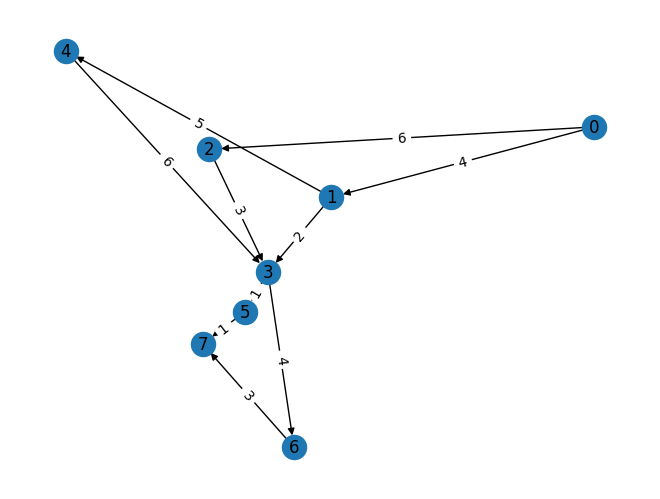

Run  1
Solution: [ 0 52  2  0 42 12 -2  0]
Best solution: [0, 0, 1, 0, 1, 0]
Best solution (path): [0, 1, 4, 3, 6, 7]
Fitness: 22.0
-------------------------------------------
Run  2
Solution: [ 0  0  2 50  2 -4 -3  5]
Best solution: [0, 0, 1, 0, 1, 0]
Best solution (path): [0, 1, 4, 3, 6, 7]
Fitness: 22.0
-------------------------------------------
Run  3
Solution: [ 0 -4 -2  0 26 62  2 59]
Best solution: [0, 0, 1, 0, 1, 0]
Best solution (path): [0, 1, 4, 3, 6, 7]
Fitness: 22.0
-------------------------------------------
Run  4
Solution: [ 0 44  6 10  2  6  4 -2]
Best solution: [0, 0, 1, 0, 1, 0]
Best solution (path): [0, 1, 4, 3, 6, 7]
Fitness: 22.0
-------------------------------------------
Run  5
Solution: [ 0  8  2 58 -2  4 23  2]
Best solution: [0, 0, 1, 0, 1, 0]
Best solution (path): [0, 1, 4, 3, 6, 7]
Fitness: 22.0
-------------------------------------------
Average time:  16.38163242340088  s
Accuracy:  100.0  %


In [225]:
times = []
correct_solutions = 0
iterations = 5
draw_digraph(graph)
for i in range(iterations):
    print("Run ", i+1)
    start = time.time()
    sol_per_pop = 500
    ga = pygad.GA(
                num_generations=1000,
                num_parents_mating=10,
                fitness_func=generate_fitness_function(graph),          
                sol_per_pop=sol_per_pop,
                num_genes=len(graph.nodes),
                crossover_type=None, # We don't want to use crossover as it will mess up the path. We fully rely on mutation
                mutation_type="random",
                initial_population=create_population(sol_per_pop, len(graph.nodes)),
                gene_type=int,
                mutation_probability=0.1,
                random_mutation_max_val=3,
                random_mutation_min_val=-3,
                keep_parents=10,
                )


    ga.run()
    end = time.time()
    times.append(end - start)
    # Get the best solution
    solution, solution_fitness, _ = ga.best_solution()
    if list(convert_solution_to_path(graph, solution)) == list(nx.dag_longest_path(graph, weight='weight')):
        correct_solutions += 1
    
    print("Solution:", solution)
    print("Best solution:",  normalize_solution(graph, solution))
    print("Best solution (path):",  convert_solution_to_path(graph, solution))
    print("Fitness:", solution_fitness)
    print("-------------------------------------------")
    
average_time = 0
for time in times:
    average_time += time
average_time = average_time / len(times)
print("Average time: ", average_time, " s")
# Accuracy is the percentage of times the algorithm found the ideal solution. We check it with the "nx.dag_longest_path" buit-in function.
accuracy = (correct_solutions / iterations) * 100
print("Accuracy: ", accuracy, " %")

Bibliography

[1] https://en.wikipedia.org/wiki/Longest_path_problem

[2] https://networkx.org/documentation/stable/reference/classes/digraph.html

[3] https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.dag_longest_path.html

[4] https://networkx.org/documentation/stable/reference/functions.html

[5] https://www.youtube.com/watch?v=YxF-x3imVFA&t=32s